In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

In [2]:
from tensorflow.keras import backend as K
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [3]:
DP_DIR = 'E:\\DLDATA\\all'
INPUT_DIR = 'E:\\DLDATA\\all\\'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [4]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)
def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [5]:

# EPOCHS = 16
# batchsize = 256
# size = 64
# STEPS = 2000#680 mobinenetV1 之前是step2000batchsize未知记得ctrl+Z

STEPS = 680
EPOCHS = 16
size = 64
batchsize = 512

In [6]:
model = MobileNetV2(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss=[focal_loss(gamma=2., alpha=.25)],
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   288         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [7]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [8]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [9]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

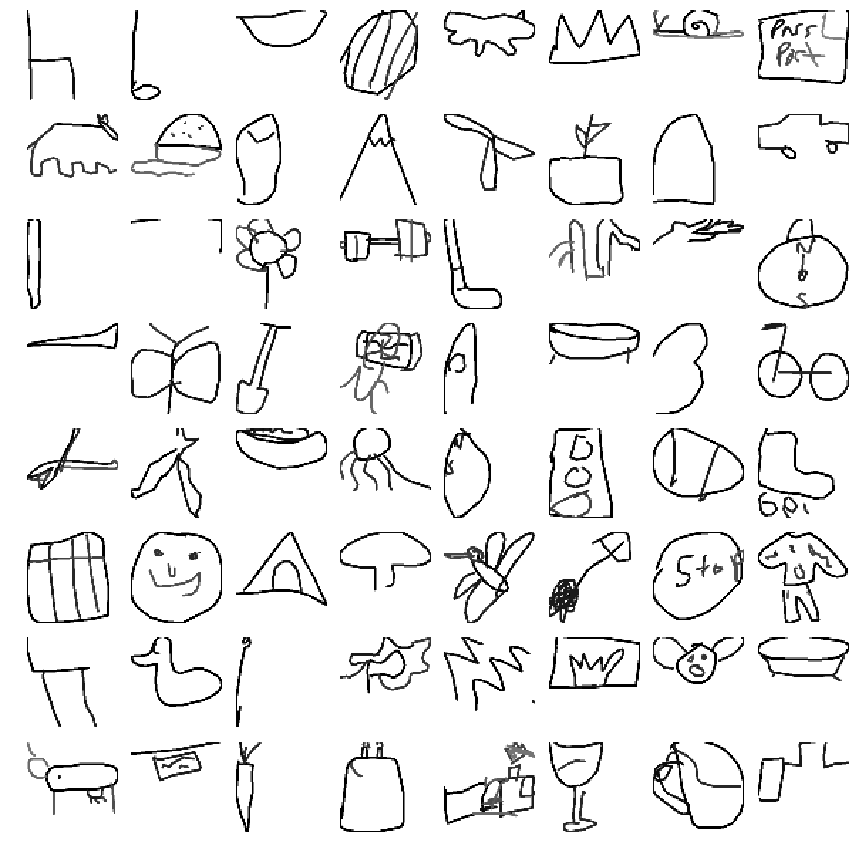

In [10]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('MobileNetV2fl.png', dpi=300)
plt.show();

In [11]:
x, y = next(train_datagen)

In [12]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
   
    ModelCheckpoint('MobileNetV2checkpointFL.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=70, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/70
680/680 [==============================] - 291s 428ms/step - loss: 376.1462 - categorical_crossentropy: 3.1831 - categorical_accuracy: 0.3025 - top_3_accuracy: 0.4863 - val_loss: 983.9926 - val_categorical_crossentropy: 7.7229 - val_categorical_accuracy: 0.0025 - val_top_3_accuracy: 0.0086
Epoch 2/70
680/680 [==============================] - 262s 386ms/step - loss: 226.2027 - categorical_crossentropy: 2.0672 - categorical_accuracy: 0.5110 - top_3_accuracy: 0.7279 - val_loss: 1177.6022 - val_categorical_crossentropy: 9.1347 - val_categorical_accuracy: 0.0030 - val_top_3_accuracy: 0.0088
Epoch 3/70
680/680 [==============================] - 264s 388ms/step - loss: 196.1398 - categorical_crossentropy: 1.8337 - categorical_accuracy: 0.5678 - top_3_accuracy: 0.7755 - val_loss: 1282.1937 - val_categorical_crossentropy: 9.8629 - val_categorical_accuracy: 0.0030 - val_top_3_accuracy: 0.0086
Epoch 4/70
680/680 [==============================] - 266s 391ms/step - loss: 181.0147 - cat

680/680 [==============================] - 265s 389ms/step - loss: 116.9789 - categorical_crossentropy: 1.1931 - categorical_accuracy: 0.7307 - top_3_accuracy: 0.8862 - val_loss: 150.7638 - val_categorical_crossentropy: 1.4257 - val_categorical_accuracy: 0.6580 - val_top_3_accuracy: 0.8409
Epoch 27/70
679/680 [============================>.] - ETA: 0s - loss: 115.6039 - categorical_crossentropy: 1.1802 - categorical_accuracy: 0.7323 - top_3_accuracy: 0.8881
Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0008437499636784196.
680/680 [==============================] - 265s 390ms/step - loss: 115.5883 - categorical_crossentropy: 1.1800 - categorical_accuracy: 0.7324 - top_3_accuracy: 0.8882 - val_loss: 392.6212 - val_categorical_crossentropy: 3.2227 - val_categorical_accuracy: 0.3085 - val_top_3_accuracy: 0.4956
Epoch 28/70
680/680 [==============================] - 265s 389ms/step - loss: 113.9504 - categorical_crossentropy: 1.1664 - categorical_accuracy: 0.7372 - top_3_accur

Epoch 50/70
679/680 [============================>.] - ETA: 0s - loss: 102.0255 - categorical_crossentropy: 1.0676 - categorical_accuracy: 0.7635 - top_3_accuracy: 0.9047
Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.000266967763309367.
680/680 [==============================] - 265s 390ms/step - loss: 102.0184 - categorical_crossentropy: 1.0675 - categorical_accuracy: 0.7635 - top_3_accuracy: 0.9047 - val_loss: 103.0460 - val_categorical_crossentropy: 1.0729 - val_categorical_accuracy: 0.7630 - val_top_3_accuracy: 0.9019
Epoch 51/70
680/680 [==============================] - 266s 391ms/step - loss: 100.9993 - categorical_crossentropy: 1.0586 - categorical_accuracy: 0.7661 - top_3_accuracy: 0.9055 - val_loss: 102.1460 - val_categorical_crossentropy: 1.0775 - val_categorical_accuracy: 0.7649 - val_top_3_accuracy: 0.9041
Epoch 52/70
680/680 [==============================] - 264s 389ms/step - loss: 100.9266 - categorical_crossentropy: 1.0589 - categorical_accuracy: 0.7657 - 

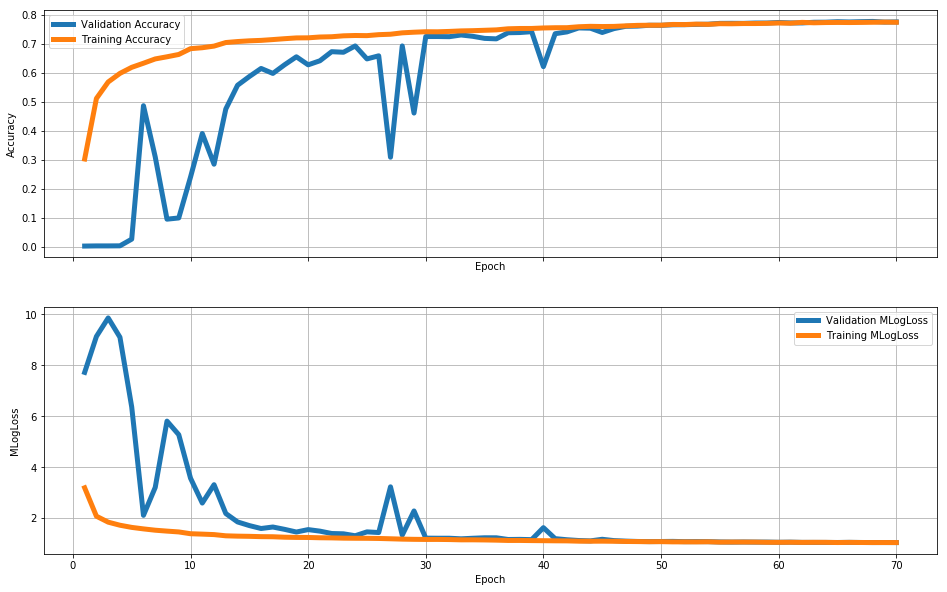

In [13]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('fig_MobileNetV2FL.png', dpi=300)
plt.show();

In [14]:
hist_df.to_csv("hist_MobileNetV2FL.csv")

In [15]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

34000/34000 [==============================] - 9s 257us/step
Map3: 0.834


In [16]:
model.save_weights("MobileNetV2FL.h5")

In [17]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 64, 64, 1)
Test array memory 1.71 GB


In [18]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 35s 311us/step


,a,b,c
0,234,281,285
1,144,36,280
2,305,62,110
3,187,303,304
4,113,56,84


(112199, 3)

,a,b,c
0,radio,stereo,stove
1,hockey_puck,bottlecap,steak
2,The_Great_Wall_of_China,castle,fence
3,mountain,tent,The_Eiffel_Tower
4,fireplace,campfire,crown


(112199, 3)

In [19]:


test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_{}MobileNetV2FL.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape



,key_id,word
0,9000003627287624,radio stereo stove
1,9000010688666847,hockey_puck bottlecap steak
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent The_Eiffel_Tower
4,9000052667981386,fireplace campfire crown


(112199, 2)

In [20]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2019-01-10 13:05:08.119028.
Total time 18659s
